*Sergey Tomin (sergey.tomin@desy.de). June 2025.*


# [`TDCavity`](https://github.com/ocelot-collab/ocelot/blob/master/ocelot/cpbd/elements/tdcavity_atom.py) – Transverse Deflecting Cavity Element

The `TDCavity` class represents a Transverse Deflecting Structure (TDS) or cavity. It is primarily used to calculate the first-order transfer matrix for a beam passing through it. This matrix describes how the phase space coordinates of particles change as they traverse the cavity. By default, the cavity provides a horizontal kick, but this can be rotated using the `tilt` parameter.

## Class Definition Snippet

In [16]:
from ocelot.cpbd.elements import TDCavity

# Example instantiation with default parameters (most are zero)
tds = TDCavity(l=0.1, freq=3e9, phi=0.0, v=0.01)  # 10 cm, S-band, 0 phase, 10 MV

# Full parameter list:
# tds = TDCavity(l=0., freq=0.0, phi=0.0, v=0., tilt=0.0, eid=None)


---

## Parameters

- **`l` (float)**: Nominal physical length of the cavity [m]. Used to scale the voltage if the actual segment length `z` differs from `l`.
- **`v` (float)**: Total peak RF voltage across the nominal length `l` [GV]. Scaled for any segment as:
  $$
  V_{\text{segment}} = v \cdot \frac{z}{l}
  $$
- **`freq` (float)**: Operating RF frequency [Hz].
- **`phi` (float)**: RF phase [degrees]. Conventionally:
  - $\phi = 0^\circ$: zero-crossing (maximum transverse kick)
  - $\phi = 90^\circ$: on-crest (maximum energy gain for accelerating cavities)
- **`tilt` (float, optional)**: Rotation angle in the transverse plane around the beam axis [rad]. A value of 0 implies horizontal kick; $\pi/2$ gives vertical.
- **`eid` (str, optional)**: Element identifier.

---

## Transfer Matrix Formulation

The `TDCavity` element generates a $6 \times 6$ transfer matrix $R$ that describes the linear transformation of a particle’s 6D phase space vector through the cavity.

### Ocelot Coordinate System

Ocelot uses the following 6D phase space convention:

$$
(x, \quad x' = \frac{p_x}{p_0}), \quad (y, \quad y' = \frac{p_y}{p_0}), \quad (\tau = c\Delta t, \quad \delta = \frac{\Delta E}{p_0 c})
$$

In code, the 6th coordinate is often labeled `p`, but here we use $\delta$ to clearly denote the relative energy deviation.


The matrix is computed by:
```python
tds_R_z(z, energy, freq, v, phi)
```

- segment length `z` [m]
- total reference energy [GeV]
- RF frequency [Hz]
- scaled voltage [GV]
- phase [deg]

---

### R-Matrix for Horizontal Deflection

The resulting matrix for a horizontally deflecting cavity segment of length $z$ is:

$$
R_{\text{code}}(z) =
\begin{bmatrix}
    1 & z & 0 & 0 & -\frac{z}{2} K \cos(\phi) & 0 \\
    0 & 1 & 0 & 0 & -K \cos(\phi) & 0 \\
    0 & 0 & 1 & z & 0 & 0 \\
    0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & -\frac{z}{\gamma^2 -1 } \\
    K \cos(\phi) & \frac{z}{2} K \cos(\phi) & 0 & 0 & -\frac{z}{6} K^2 \cos(2\phi) & 1
\end{bmatrix}
$$

Where:

- $K = \dfrac{V_{\text{seg}} \cdot k_0}{p_0 c}$ — normalized TDS strength (dimensionless)
- $k_0 = \dfrac{2\pi f}{c}$ — RF wavenumber [1/m]
- $p_0 c = m_e c^2 \sqrt{\gamma^2 - 1}$ — reference momentum-energy [GeV]
- $\gamma = \dfrac{E_{\text{ref}}}{m_e c^2}$ — Lorentz factor

The matrix is later rotated if a `tilt` is applied.

---

## Application: Induced Slice Energy Spread

Due to the **Panofsky–Wenzel theorem**, a transverse deflecting field with time (or longitudinal position) dependence must be accompanied by a longitudinal field component depending on transverse coordinates. This results in an **induced energy deviation** across the bunch [[1](https://accelconf.web.cern.ch/d07/papers/tupb32.pdf), [2](https://epaper.kek.jp/d09/papers/tupb44.pdf)].

The relative energy deviation of the **central slice ($\tau = 0$)** at the cavity exit is:

$$
\delta_f = \delta_0 + R_{61} x_0 + R_{62} x_0' + R_{66} \delta_0
$$

With $R_{66} = 1$ and defining $a = K \cos\phi$, we get:

$$
\Delta \delta = \delta_f - \delta_0 = a x_0 + \frac{z}{2} a x_0'
$$

So the new energy deviation becomes:

$$
\delta_1 = \delta_0 + \Delta \delta
$$

### RMS Energy Spread

We compute the final slice energy spread:

$$
\sigma_\delta^2 = \langle \delta_1^2 \rangle - \langle \delta_1 \rangle^2
$$

Assuming:
- $\langle x_0 \rangle = \langle x_0' \rangle = \langle \delta_0 \rangle = 0$ - the beam does not have any offsets.
- $\langle \delta_0 x_0 \rangle = \langle \delta_0 x_0' \rangle = 0$ - there are no correlations in the beam between energy and transverse coordinates. 

We obtain:

$$
\sigma_\delta^2(z) = \langle \delta_0^2 \rangle + a^2 \langle x_0^2 \rangle + z a^2 \langle x_0 x_0' \rangle + \frac{z^2 a^2}{4} \langle (x_0')^2 \rangle
$$

### Using Twiss Parameters:

- $\langle x_0^2 \rangle = \varepsilon_x \beta_x$
- $\langle x_0 x_0' \rangle = -\varepsilon_x \alpha_x$
- $\langle (x_0')^2 \rangle = \varepsilon_x \gamma_x^{\text{Twiss}}$

Then the induced energy spread from the TDS becomes:

$$
(\sigma_\delta^2)_{\text{TDS}} = a^2 \varepsilon_x \left( \beta_x - z \alpha_x + \frac{z^2}{4} \gamma_x^{\text{Twiss}} \right)
$$

Or:

$$
(\sigma_\delta)_{\text{TDS}} = |K \cos\phi| \cdot \sqrt{ \varepsilon_x \left( \beta_x(0) - z \alpha_x(0) + \frac{z^2}{4} \gamma_x^{\text{Twiss}}(0) \right) }
$$

> *Note: Here, $\gamma$ (no subscript) is the relativistic Lorentz factor, while $\gamma_x^{\text{Twiss}}$ is the Twiss parameter.*

**This expression was used in [[3](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.064201)].** 

---
### References 
1. [S.Korepanov et al, AN RF DEFLECTOR FOR THE LONGITUDINAL AND TRANSVERSE
BEAM PHASE SPACE ANALYSIS AT PITZ](https://accelconf.web.cern.ch/d07/papers/tupb32.pdf)
2. [C. Behrens and C. Gerth, ON THE LIMITATIONS OF LONGITUDINAL PHASE SPACE
MEASUREMENTS USING A TRANSVERSE DEFLECTING STRUCTURE](https://epaper.kek.jp/d09/papers/tupb44.pdf)
3. [S.Tomin et al, Accurate measurement of uncorrelated energy spread in electron beam, Phys. Rev. Accel. Beams 24, 064201](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.064201)
   
## Summary

The `TDCavity` provides a time-dependent transverse kick to the beam. According to the **Panofsky–Wenzel theorem**, this results in a correlated longitudinal effect, increasing the slice energy spread. 

## Examples of Use

### 1. Basic Instantiation and Transfer Matrix Calculation

In [53]:
import numpy as np
from ocelot.cpbd.elements import TDCavity

import numpy as np
from ocelot.cpbd.elements import TDCavity

# Create a TDCavity element: 1 meter long, S-band frequency, 0° phase, 30 MV voltage
tds = TDCavity(l=1.0, freq=3e9, phi=0.0, v=0.03)

# Print the first-order transfer matrix at 1 GeV
np.set_printoptions(precision=3, suppress=True)
print(tds.R(energy=1.0))  # [GeV]

[array([[ 1.   ,  1.   ,  0.   ,  0.   , -0.943,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   , -1.886,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   , -0.   ],
       [ 1.886,  0.943,  0.   ,  0.   , -0.593,  1.   ]])]


## Tracking with TDS: Visualizing the Current Profile

In this example, we demonstrate how a **Transverse Deflecting Cavity (TDS)** can be used to convert the **longitudinal structure** of a bunch into a **transverse streak**, making it observable on a screen.

We generate a particle distribution with a **triangular current profile** and propagate it through a simple beamline that includes a TDS. The final transverse (x) distribution at the exit should mirror the original current shape, allowing us to confirm the streaking effect.

> ⚠️ In this example, we are only interested in the **shape** of the profile, not its absolute amplitude.

We use:
- [`MagneticLattice`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/magnet-lattice) to define the beamline,
- [`ParticleArray`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/particle-array) class,
- [Twiss](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/twiss) class,
- [generate_parray()](https://www.ocelot-collab.com/docs/docu/functions/generate_parray) to generate the particle distribution,
- and [track()](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/tracking) function for [`ParticleArray`](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/particle-array) tracking. 

If you're interested in more details about how the TDS works and its impact on beam diagnostics, see this [Optics for High Time Resolution Measurements with TDS](https://www.ocelot-collab.com/docs/tutorial/tutorial-beam-dynamics/optics_design).

[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


z = 11.599999999999998 / 11.599999999999998. Applied: 

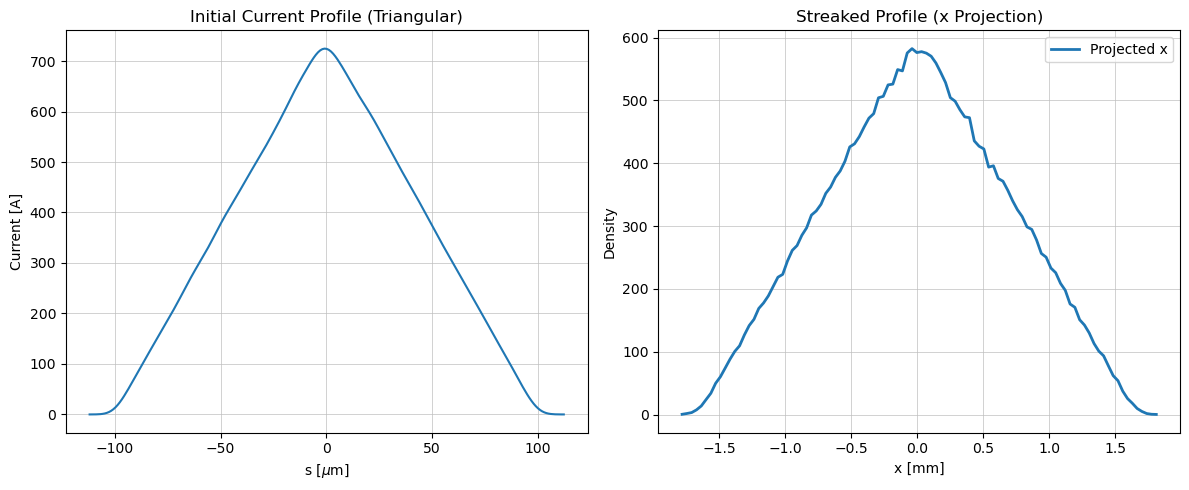

In [61]:
from ocelot import *
from ocelot.gui import *
# Define TDS and lattice
tds = TDCavity(l=1.0, freq=3e9, phi=0.0, v=0.03)
d = Drift(l=1.0)
qf = Quadrupole(l=0.2, k1=1.0)
qd = Quadrupole(l=0.2, k1=-1.0)
lat = MagneticLattice([tds, d] + list((qf, d, qd, d) * 4))

# Define initial Twiss parameters
tws0 = Twiss(beta_x=10, beta_y=10, alpha_x=-1, alpha_y=0.8, emit_xn=1e-6, emit_yn=1e-6, E=1.0)

# Generate triangular-shaped longitudinal distribution
parray = generate_parray(tws=tws0, charge=250e-12, sigma_p=1e-4,
                         chirp=0, sigma_tau=1e-4, nparticles=500_000, shape="tri")

# Initial current profile
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
current_profile = parray.I()
plt.plot(current_profile[:, 0]*1e6, current_profile[:, 1])
plt.title("Initial Current Profile (Triangular)")
plt.xlabel(r"s [$\mu$m]")
plt.ylabel("Current [A]")

# Track particles through the lattice (TDS will convert τ → x)
track(lat, parray)

# Plot streaked distribution (projected on x)
plt.subplot(1, 2, 2)
counts, bin_edges = np.histogram(parray.x(), bins=100, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers*1e3, counts, label="Projected x", linewidth=2)
plt.title("Streaked Profile (x Projection)")
plt.xlabel("x [mm]")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 3. Slice Energy Spread Growth Due to TDS

In this example, we illustrate how the Transverse Deflecting Structure (TDS) increases the **slice energy spread** due to the Panofsky–Wenzel effect, and compare the result with the analytical prediction derived earlier.

> 📌 **Note:** The slice energy spread should be evaluated in a **narrow time window around** $\tau = 0$, as assumed in the derivation above. This ensures the comparison with theory is valid.

In [57]:
# Generate fresh distribution without triangular shape
parray = generate_parray(tws=tws0, charge=250e-12, sigma_p=1e-4,
                         chirp=0, sigma_tau=1e-4, nparticles=500_000)

# Track through lattice
track(lat, parray)

# Compute energy spread from particle distribution in a small slice
sigma_p_measured = np.sqrt(parray.get_twiss(bounds=[-0.1, 0.1]).pp)
print(f"Measured σ_p from slice: {sigma_p_measured:.3e}")

# Analytical estimate using Panofsky-Wenzel formulation
Ktds = tds.v * 2 * np.pi * tds.freq / (parray.E * speed_of_light)
sigma_E_tds = Ktds * np.cos(tds.phi) * np.sqrt(
    tws0.emit_x * (tws0.beta_x - tds.l * tws0.alpha_x + (tds.l**2 / 4) * tws0.gamma_x)
)
sigma_total = np.sqrt((1e-4)**2 + sigma_E_tds**2)

print(f"Analytical σ_p after TDS: {sigma_total:.3e}")


[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


z = 11.599999999999998 / 11.599999999999998. Applied: inside =  39984
Measured σ_p from slice: 1.734e-04
Analytical σ_p after TDS: 1.735e-04
